# GeoRegression

**Author:** Andrew Mehrmann

**Organization:** The Cline Center for Democracy, The Laboratory for Cosmological Data Mining

**Date:** May 2016

***

## Abstract

One of the joint research interests of our organizations is the geocoding of text articles using either metadata or textual content of the documents. This work aims to explore machine learning or statistical modeling approaches to predicting an output $(lat, lon)$ given some inputs $X$ by approximating a function $g(X)$. This is not a new framework, but we intend to survey and perhaps expand on existing approaches to predicting a bivariate response, specifically when that response is a set of coordinates on a sphere. 

In [1]:
%matplotlib inline

In [2]:
from helper import *
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

## Preliminaries

* Load (sample of) unigrams and the top geolocation from the Solr index into a Pandas DataFrame
* Write to csv

In [3]:
def get_top_coord(uni_id, NYT_KEY):
    a, b, c, d = get_geo_data(uni_id, NYT_KEY)
    try:
        return map(float, a.iloc[0,0].split(','))
    except: 
        return ['NA', 'NA']
    
def get_row(uni_id, NYT_KEY):
    df1 = pd.DataFrame(pd.Series(unigrams[uni_id]['counts'])).T
    df2 = pd.DataFrame(get_top_coord(uni_id, NYT_KEY), index=['LAT', 'LON']).T
    return pd.concat([df2,df1], axis=1)

In [4]:
'''
result = get_row(0, NYT_KEY)
for i in range(1,1000): # sample of 1000
    try:
        r = get_row(i, NYT_KEY)
        result = pd.concat([result, r])
    except:
        pass
    time.sleep(0.3)

result = result.fillna(0)
'''

'\nresult = get_row(0, NYT_KEY)\nfor i in range(1,1000): # sample of 1000\n    try:\n        r = get_row(i, NYT_KEY)\n        result = pd.concat([result, r])\n    except:\n        pass\n    time.sleep(0.3)\n\nresult = result.fillna(0)\n'

In [5]:
# result.to_csv('regress_data_sample.csv', encoding='utf-8') # 1000 is 59 MB
result = pd.read_csv('regress_data_sample.csv')

## Predicting Geospatial Coordinates

Predicting Latitude and Longitude with standard linear regression presents unique challenges:

1. The latitudes and longitudes may not be independent
2. They are not normally distributed
3. Longitude increases from 0 to 180, then skips to -180 and decreases until it approaches 0 from the left

For these reasons statisticians have developed techniques called *spatial regression*. The project will eventually get to that, but for now **we will address some of the issues above without exploring that topic**. Specifically, this notebook will focus on exploring concepts related to the prediction of latitudes and longitudes.

To use the usual statistical and algorithmic approaches to prediction, we must transform the dependent variables in some way. We could:

1. Map the latitudes and longitudes to a single unique value, perform predictions, then map the prediction back to a latitude and longitude
2. Use a technique that is designed for (or doesn't care about) correlated dependent variables
3. Use a technique to decorrelate the dependent variables, then use separate models on the transformed $Y$

## Mapping to a Single Unique Value

#### Pairing Functions

A [pairing function](https://en.wikipedia.org/wiki/Pairing_function) maps two *natural numbers* (positive or non-negative integers) to a single unique natural number. One example of this is the *Cantor Pairing Function* given as 

$$\pi(n_1, n_2) = \frac{1}{2}(n_1+n_2)(n_1+n_2+1)+n_2$$

where, for example, the natural numbers $2$ and $3$ get mapped to 18. Given 18 as the output from a model, for example, the Cantor function is invertible such that the values 2 and 3 can be retreived. This concept only works for natural numbers, so we would have to convert the coordinates to natural numbers by multiplying by powers of 10 and shifting the negative longitudes. This extends the pairing function to *Real Numbers*, or at least those that constitute latitude and longitude.
![caption](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Pairing_natural.svg/429px-Pairing_natural.svg.png)

#### Convert Lat/Lon to Positive Integers

In [6]:
def ll2int(lat, lon, n):
    '''
    lat is a latitude
    lon is a longitude
    n is the number of decimals to keep
    '''
    
    intlat = int(lat*10**n)
    intlon = int((lon+180)*10**n)
    return intlat, intlon
    
def int2ll((intlat, intlon), n):
    '''
    intlat is the lat created from ll2int
    intlon is the lon created from int2ll
    n is the same n from ll2int
    '''
    lat = intlat/float((10**n))
    lon = intlon/float(10**n)-180
    return lat, lon

In [7]:
lat = 42.00125
lon = -62.04031
g = ll2int(lat, lon, 4)
g

(420012, 1179596)

#### Cantor Pairing Function

In [8]:
def cantor(n1, n2):
    return 0.5*(n1 + n2)*(n1 + n2 + 1)+n2

def inv_cantor(z):
    w = ((8*z)**(0.5)-1)//2
    t = (w**2 + w)/2
    y=z-t
    x=w-y
    return x,y

In [9]:
p = inv_cantor(cantor(g[0], g[1]))
int2ll(p, 4)

(42.0012, -62.040400000000005)

#### Space-filling Curves

Another option would be to map latitudes and longitudes to their position along a [space-filling curve](https://en.wikipedia.org/wiki/Space-filling_curve). This is a technique to translate between $R^2$ and $R$.

![caption](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Peanocurve.svg/931px-Peanocurve.svg.png)

The following code was taken from [Wikipedia](https://en.wikipedia.org/wiki/Hilbert_curve) and translated from C to Python with help from [@dentearl](https://github.com/dentearl/simpleHilbertCurve/blob/master/src/simpleHilbertCurve.py). It will translate back and forth between $R^2$ and $R$ using a Hilbert Curve.

In [10]:
def xy2d(n, x, y):
    d=0
    s=n/2
    while (s > 0):
        rx = (x & s) > 0
        ry = (y & s) > 0
        d += s * s * ((3 * rx) ^ ry)
        x,y = rot(s, x, y, rx, ry)
        s/=2
    return d

def d2xy(n, d):
    """
    take a d value in [0, n**2 - 1] and map it to
    an x, y value (e.g. c, r).
    """
    assert(d <= n**2 - 1)
    t = d
    x = y = 0
    s = 1
    while (s < n):
        rx = 1 & (t / 2)
        ry = 1 & (t ^ rx)
        x, y = rot(s, x, y, rx, ry)
        x += s * rx
        y += s * ry
        t /= 4
        s *= 2
    return x, y

def rot(n, x, y, rx, ry):
    """
    rotate/flip a quadrant appropriately
    """
    if ry == 0:
        if rx == 1:
            x = n - 1 - x
            y = n - 1 - y
        return y, x
    return x, y

$n$ must be a power of two and $d<n^2 - $, so for $n=2^4=16$, the maximum $d$ would be $16^2 - 1 = 255$

In [11]:
xy2d(n=2**4, x=2, y=5)

55

In [12]:
d2xy(n=2**4, d=55)

(2, 5)

## Techniques for Correlated Dependent Variables

MANOVA - http://psych.colorado.edu/~carey/qmin/qminchapters/qmin13-glm_multivariate.pdf

## Transformation of Dependent Variables

Predicting multiple dependent variables is called *multivariate linear regression*, not to be confused with *multivariable linear regression* or *multiple linear regression*. If the dependent variables are uncorrelated, then the usual least squares estimate

$$\hat{B} = (X^TX)^{-1}X^TY$$

extends to an $n \times k$ matrix $Y$. This will give the *exact same* values of $B$ as $k$ separate linear models on each column of $Y$ would give. If the variables *are* correlated, this method doesn't utilize that information and may result in correlated errors. To use the least squares estimator above, we could first use PCA on the dependent variables to map them to two uncorrelated variables, build a model and get a prediction, then map the PCs back to the dependent variables.

In our sample of 1000 coordinates articles, the correlation between the latitude and longitude is $-.187$.

In [15]:
result[['LAT', 'LON']].convert_objects(convert_numeric=True).dropna().corr()

,LAT,LON
LAT,1.000000,-0.187488
LON,-0.187488,1.000000


This, however, does not mean that they are not independent. The plot below illustrates this:

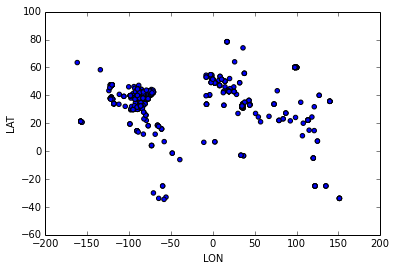

In [16]:
result[['LAT', 'LON']].convert_objects(convert_numeric=True).dropna().plot.scatter(x='LON', y='LAT')

These certainly don't look independent of each other. This plot is actually a lot like a [Mercator Projection](https://en.wikipedia.org/wiki/Mercator_projection) and we can plot the same points on a map:

In [44]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

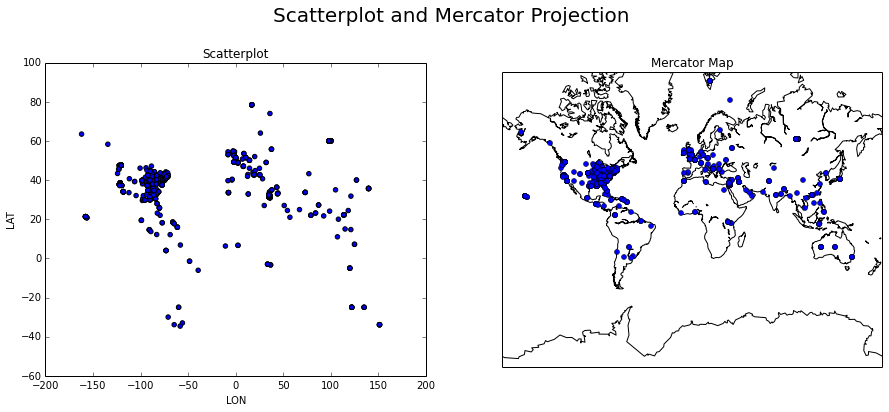

In [46]:
fig = plt.figure(figsize=(16, 6), dpi=80)

ax1 = fig.add_subplot(121)
result[['LAT', 'LON']].convert_objects(convert_numeric=True).dropna().plot.scatter(x='LON', 
                                                                                   y='LAT', 
                                                                                   ax=ax1, 
                                                                                   figsize=(15,6))
ax2 = fig.add_subplot(122)
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c', ax=ax2)
m.drawcoastlines()

x, y = m(result['LON'].values, result['LAT'].values) # IS LON, LAT !!!!

m.plot(x, y, 'bo', markersize=5, alpha=1)


fig.suptitle('Scatterplot and Mercator Projection\n', fontsize=20)
ax1.set_title("Scatterplot")
ax2.set_title('Mercator Map')
plt.subplots_adjust(top=0.85)


plt.show()

#### Independent Component Analysis

The above illustrates a fundamental problem with using PCA to this end. PCA will guarantee that the resulting PCs have a correlation of 0, but it does not guarantee that the PCs will be *independent*. Zero correlation *does* imply independence in the case of multivariate normal data, but we don't want to restrict our analysis to only those cases. Instead, we can use *Independent* Component Analysis to transform the matrix $Y$. For more information about ICA, see [here](https://www.cs.helsinki.fi/u/ahyvarin/whatisica.shtml) and [here](http://stats.stackexchange.com/questions/35319/what-is-the-relationship-between-independent-component-analysis-and-factor-analy).

In [47]:
from sklearn.decomposition import FastICA, PCA

Y = result[['LAT', 'LON']].convert_objects(convert_numeric=True).dropna()

ica = FastICA(random_state=1738)
S_ica_ = ica.fit(Y).transform(Y)

pca = PCA()
S_pca_ = pca.fit(Y).transform(Y)

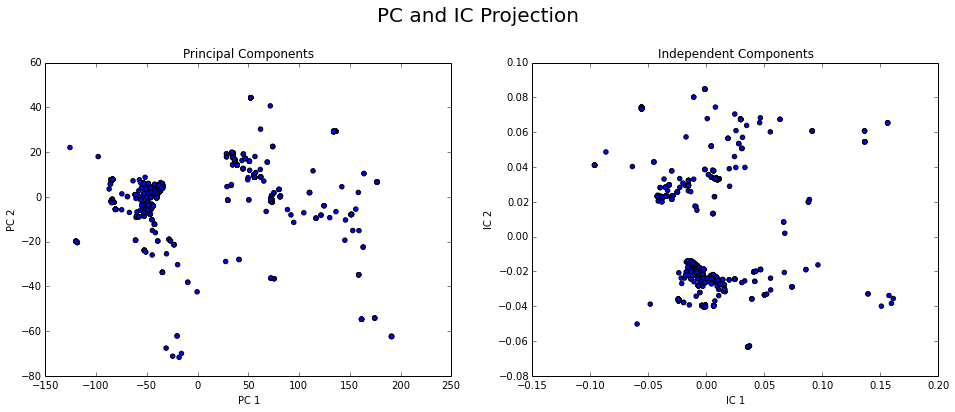

In [48]:
fig = plt.figure(figsize=(16, 6), dpi=80)

ax1 = fig.add_subplot(121)
pd.DataFrame(S_pca_,columns=['PC 1', 'PC 2']).plot.scatter(x='PC 1', y='PC 2', ax=ax1)

ax2 = fig.add_subplot(122)
pd.DataFrame(S_ica_,columns=['IC 1', 'IC 2']).plot.scatter(x='IC 1', y='IC 2', ax=ax2)


fig.suptitle('PC and IC Projection\n', fontsize=20)
ax1.set_title("Principal Components")
ax2.set_title('Independent Components')
plt.subplots_adjust(top=0.85)

plt.show()

## Additional Resources

http://www.aclweb.org/anthology/W15-1527